# DurAIn-ni (train model)

Install from pypi...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

--2022-07-15 07:40:17--  https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2820 (2.8K) [text/plain]
Saving to: ‘icevision_install.sh’

icevision_install.s 100%[===================>]   2.75K  --.-KB/s    in 0s      

2022-07-15 07:40:18 (42.2 MB/s) - ‘icevision_install.sh’ saved [2820/2820]



In [ ]:
import subprocess
try: # เช็คว่ามี GPU รึเปล่า
    subprocess.check_output('nvidia-smi')
    print('มี GPU!')
    print('ทำการติดตั้งสำหรับ CUDA 11 เพื่อใช้งาน GPU')
    process = 'cuda11'    

except Exception: # ถ้าไม่มี
    print('ไม่มี GPU ลงเวอร์ชั่น CPU!')
    process = 'cpu'   

!bash icevision_install.sh {process} master #เรียกใช้งาน Script

มี GPU!
ทำการติดตั้งสำหรับ CUDA 11 เพื่อใช้งาน GPU
Installing icevision + dependencices for cuda11
- Installing torch and its dependencies
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████▌                   | 834.1 MB 1.3 MB/s eta 0:16:22tcmalloc: large alloc 1147494400 bytes == 0x399ac000 @  0x7f7427ee6615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███████████████▉                | 1055.7 MB 1.2 MB/s eta 0:15:07tcmalloc: large alloc 1434370048 bytes == 0x7e002000 @  0x7f7427ee6615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f6

In [ ]:
from icevision.all import parsers, tfms, Dataset, models, COCOMetric, COCOMetricType, PIL, SimpleConfusionMatrix, show_samples, ClassMap

In [ ]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir="/content/drive/MyDrive/Prototype_leaf(VOC)/annotations",
                               images_dir="/content/drive/MyDrive/Prototype_leaf(VOC)/images")
train_records, valid_records = parser.parse()

  0%|          | 0/1263 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/1263 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 25_spot_jpg.rf.633fe58f831a5dd48993f24504c809d7) - Clipping bbox xmax from 513 to image width 512 (Before: <BBox (xmin:9, ymin:2, xmax:513, ymax:473)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 25_spot_jpg.rf.67ce138e4a3cc8f2359bdd08ea08e45f) - Clipping bbox xmax from 513 to image width 512 (Before: <BBox (xmin:9, ymin:41, xmax:513, ymax:512)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 25_spot_jpg.rf.fa5a52d0a52d2d743e57380d1f6c764c) - Clipping bbox xmax from 513 to image width 512 (Before: <BBox (xmin:9, ymin:41, xmax:513, ymax:512)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 271_d5d62f10_jpg.rf.4f99a1dac6e79722feaf861f4e2e5caf) - Clipping bbox xmax from 513 to image width 512 (Before: <BBox (xmin:400, ymin:144, xmax:513, ymax:259)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 271_d5d62f10_jpg.rf.d0fa1f665af03204847180ff822

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [ ]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
from PIL import *

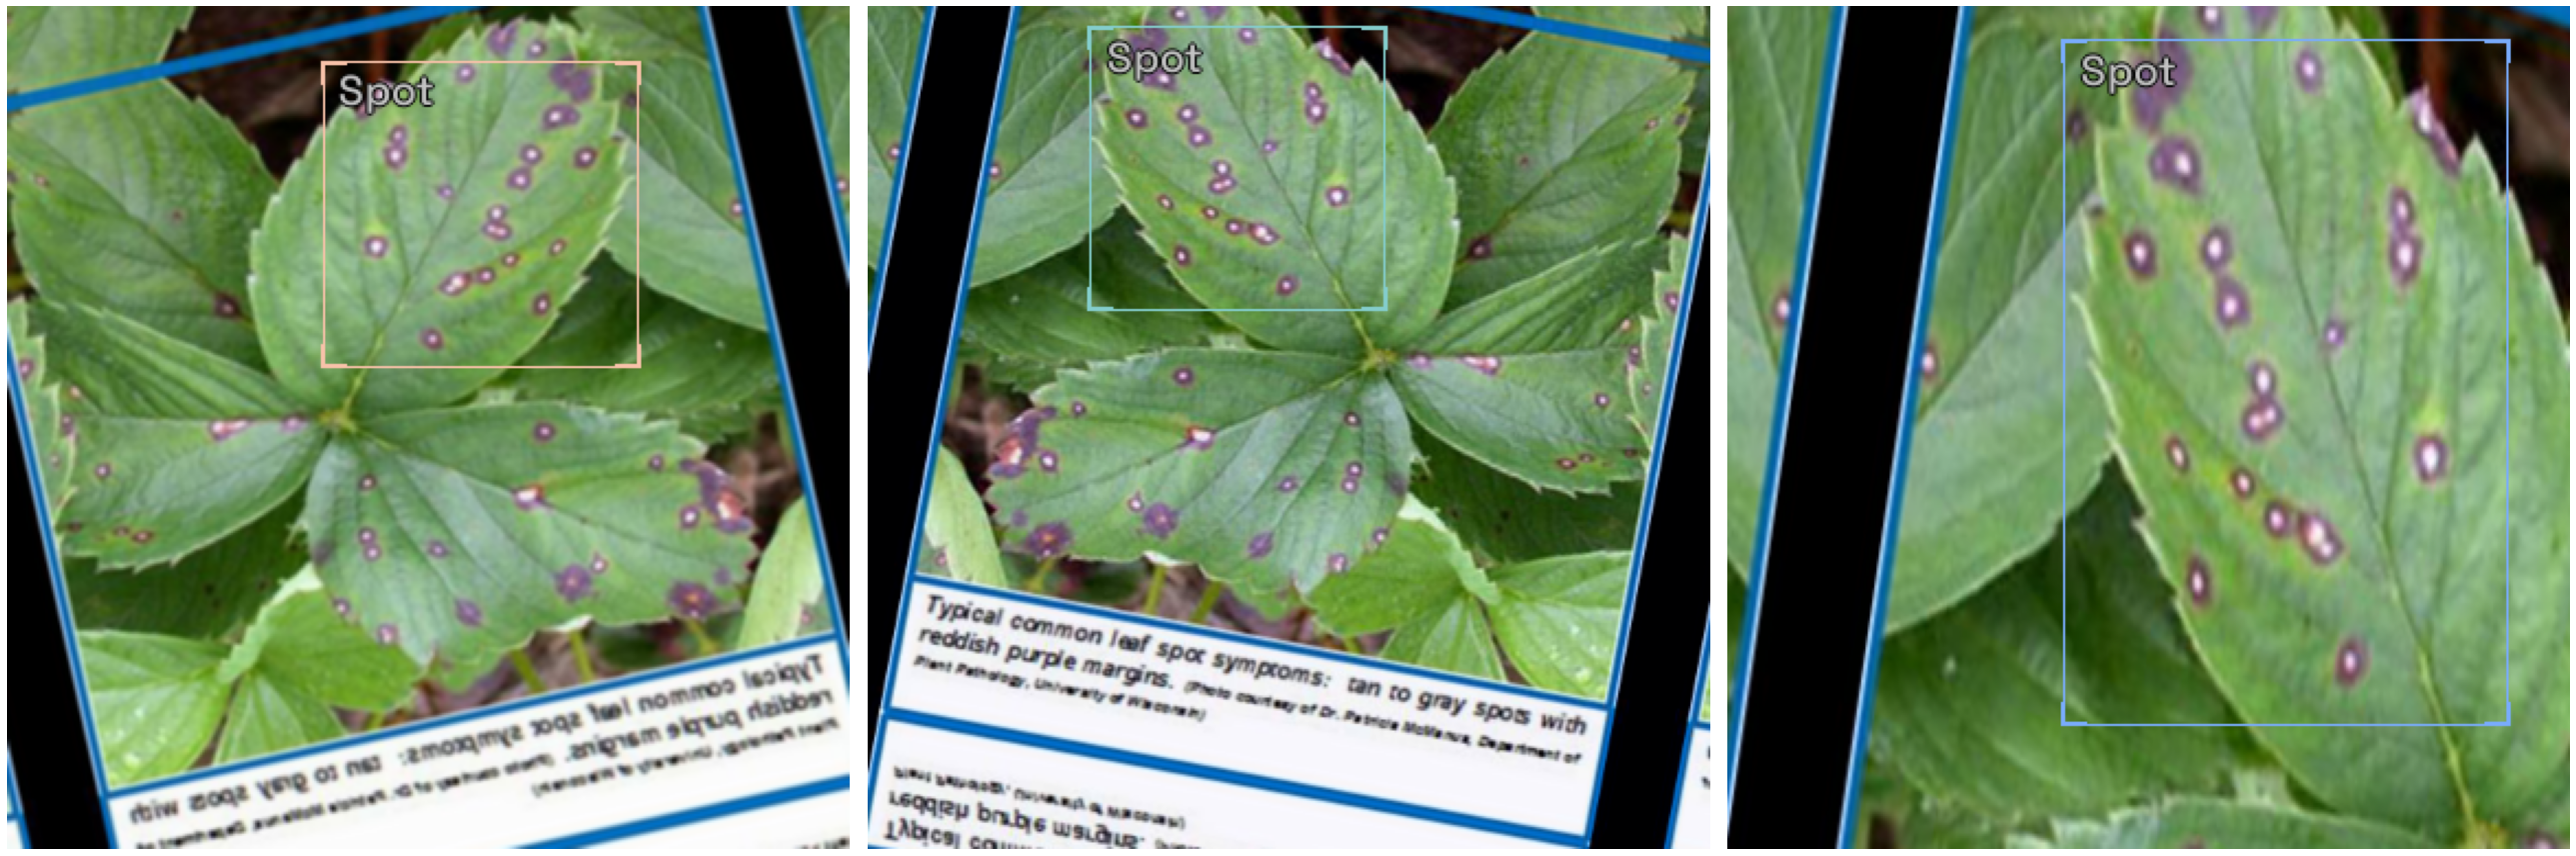

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[17] for _ in range(3)]
show_samples(samples, ncols=3)

In [ ]:
# Just change the value of selection to try another model

selection = 2

extra_args = {}

if selection == 0:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.resnet50_fpn_mstrain_2x

if selection == 1:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  # extra_args['cfg_options'] = { 
  #   'model.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 2:
  model_type = models.mmdet.faster_rcnn
  backbone = model_type.backbones.resnet101_fpn_2x
  # extra_args['cfg_options'] = { 
  #   'model.roi_head.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.roi_head.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 3:
  model_type = models.mmdet.ssd
  backbone = model_type.backbones.ssd300

if selection == 4:
  model_type = models.mmdet.yolox
  backbone = model_type.backbones.yolox_s_8x8

if selection == 5:
  model_type = models.mmdet.yolof
  backbone = model_type.backbones.yolof_r50_c5_8x8_1x_coco

if selection == 6:
  model_type = models.mmdet.detr
  backbone = model_type.backbones.r50_8x2_150e_coco

if selection == 7:
  model_type = models.mmdet.deformable_detr
  backbone = model_type.backbones.twostage_refine_r50_16x2_50e_coco

if selection == 8:
  model_type = models.mmdet.fsaf
  backbone = model_type.backbones.x101_64x4d_fpn_1x_coco

if selection == 9:
  model_type = models.mmdet.sabl
  backbone = model_type.backbones.r101_fpn_gn_2x_ms_640_800_coco

if selection == 10:
  model_type = models.mmdet.centripetalnet
  backbone = model_type.backbones.hourglass104_mstest_16x6_210e_coco

elif selection == 11:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn #resnet50_fpn

elif selection == 12:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 13:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 14:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_d2
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.faster_rcnn' from '/usr/local/lib/python3.7/dist-packages/icevision/models/mmdet/models/faster_rcnn/__init__.py'>,
 {})

In [ ]:
model_type = models.ross.efficientdet
backbone = model_type.backbones.tf_d2
# The efficientdet model requires an img_size parameter
extra_args['img_size'] = image_size

In [ ]:
backbone.__dict__

{'config_path': Path('/root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs/faster_rcnn/faster_rcnn_r101_fpn_2x_coco.py'),
 'model_name': 'faster_rcnn',
 'weights_url': 'http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r101_fpn_2x_coco/faster_rcnn_r101_fpn_2x_coco_bbox_mAP-0.398_20200504_210455-1d2dac9c.pth'}

In [ ]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

  0%|          | 0/243518604 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2022-07-15 08:33:59,194 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet101'}
2022-07-15 08:33:59,196 - mmcv - INFO - load model from: torchvision://resnet101
2022-07-15 08:33:59,198 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet101
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

2022-07-15 08:34:02,283 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-07-15 08:34:02,361 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-07-15 08:34:02,389 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-07-15 08:34:02,398 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'layer': 'Linear', 'override': [{'name': 'shared_fcs'}, {'name': 'cls_fcs'}, {'name': 'reg_fcs'}]}]
2022-07-15 08:34:02,612 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-07-15 08:34:02,614 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: load from 

load checkpoint from local path: checkpoints/faster_rcnn/faster_rcnn_r101_fpn_2x_coco_bbox_mAP-0.398_20200504_210455-1d2dac9c.pth
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([6, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([6]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([20, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([20]).


In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# show batch
model_type.show_batch(first(valid_dl), ncols=6)

NameError: ignored

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox), SimpleConfusionMatrix(print_summary=True)]

### Training using fastai

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=7.585775892948732e-05)

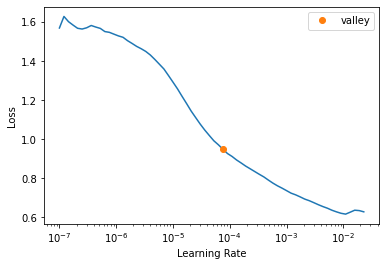

In [ ]:
learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

In [ ]:
!nvidia-smi

Mon Jun  6 16:45:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |  16245MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
learn.fine_tune(100, 10e-4, freeze_epochs=1)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [25 12  0  0  5  8]
 [ 8  1  0  0  3  7]
 [ 3  2  1  0  1 10]
 [36  0  0  0 27  3]
 [21  6  0  0  9 61]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 45  0  0  1  2]
 [ 2  4  4  6  1  2]
 [ 0  0  5  9  3  0]
 [13  2  0  0 51  0]
 [ 2  5  0  0  0 90]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 46  0  0  0  2]
 [ 3  0 10  5  0  1]
 [ 0  0 10  7  0  0]
 [15  0  0  0 49  2]
 [ 4  1  0  0  0 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 1 47  0  0  0  2]
 [ 2  0 10  6  0  1]
 [ 0  0  6 11  0  0]
 [ 4  0  0  0 62  0]
 [ 3  0  0  0  2 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 3  0 12  3  0  1]
 [ 0  0 10  7  0  0]
 [13  2  0  0 51  0]
 [ 1  2  1  0  2 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 1 49  0  0  0  0]
 [ 3  0  8  7  0  1]
 [ 0  0  5 12  0  0]
 [ 6  0  0  0 60  0]
 [ 0  0  1  0  2 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 4 46  0  0  0  0]
 [ 2  0 10  6  0  1]
 [ 0  0  2 15  0  0]
 [ 7  0  0  0 57  2]
 [ 2  1  0  0  2 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 1 49  0  0  0  0]
 [ 2  1 12  4  0  0]
 [ 0  0  4 13  0  0]
 [ 9  1  0  0 56  0]
 [ 1  1  0  0  2 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 48  0  0  0  0]
 [ 2  0 15  1  0  1]
 [ 0  0 10  7  0  0]
 [10  0  0  0 56  0]
 [ 1  0  1  0  0 95]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 3 47  0  0  0  0]
 [ 2  1 14  2  0  0]
 [ 0  0  3 14  0  0]
 [11  2  0  0 53  0]
 [ 3  0  0  0  1 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 3 47  0  0  0  0]
 [ 2  0 11  5  0  1]
 [ 0  0  0 16  0  1]
 [ 9  0  0  0 55  2]
 [ 0  0  0  0  0 97]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 48  0  0  0  0]
 [ 3  0 13  2  0  1]
 [ 0  0  1 16  0  0]
 [ 7  0  0  0 58  1]
 [ 2  1  0  0  0 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 48  0  0  0  0]
 [ 3  0 16  0  0  0]
 [ 2  0  1 14  0  0]
 [ 7  0  0  0 59  0]
 [ 4  1  0  0  1 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 0 50  0  0  0  0]
 [ 2  0 17  0  0  0]
 [ 0  0  9  8  0  0]
 [11  0  0  0 55  0]
 [ 6  1  0  0  0 90]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 0 50  0  0  0  0]
 [ 4  0 10  4  0  1]
 [ 0  0  0 14  2  1]
 [ 6  0  0  0 60  0]
 [ 3  1  0  0  1 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 0 49  0  0  0  1]
 [ 5  0 11  2  0  1]
 [ 3  0  0 14  0  0]
 [14  0  0  0 52  0]
 [ 2  1  0  0  1 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 0 49  1  0  0  0]
 [ 3  1 15  0  0  0]
 [ 0  0  6 11  0  0]
 [11  0  0  0 51  4]
 [ 2  1  0  0  0 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 3 47  0  0  0  0]
 [ 4  0 12  3  0  0]
 [ 0  0  2 15  0  0]
 [11  0  0  0 55  0]
 [ 1  1  0  0  0 95]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 4 46  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  7  8  0  0]
 [15  0  0  0 51  0]
 [ 1  1  0  0  0 95]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 1 49  0  0  0  0]
 [ 4  0 14  1  0  0]
 [ 1  0  1 15  0  0]
 [15  0  0  0 51  0]
 [ 2  0  0  0  0 95]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 4 46  0  0  0  0]
 [ 3  1 14  0  1  0]
 [ 2  0  5 10  0  0]
 [15  0  0  0 51  0]
 [ 3  1  0  0  1 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 48  0  0  0  0]
 [ 3  0 16  0  0  0]
 [ 1  0  1 15  0  0]
 [11  0  0  0 55  0]
 [ 2  1  3  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 4  0 14  0  1  0]
 [ 2  0  1 14  0  0]
 [16  0  0  0 50  0]
 [ 5  0  0  0  0 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 48  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 1  0  1 15  0  0]
 [15  0  0  0 51  0]
 [ 8  0  0  0  1 88]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 4 46  0  0  0  0]
 [ 5  1 12  1  0  0]
 [ 2  0  4 11  0  0]
 [17  0  0  0 49  0]
 [ 3  6  0  0  2 86]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 6  0 12  1  0  0]
 [ 2  0  4 11  0  0]
 [15  0  0  0 51  0]
 [ 2  1  1  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 0 49  1  0  0  0]
 [ 3  0 15  1  0  0]
 [ 2  0  1 14  0  0]
 [14  0  0  0 52  0]
 [ 3  0  0  0  0 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 3 47  0  0  0  0]
 [ 3  2 13  1  0  0]
 [ 3  0  0 14  0  0]
 [12  0  0  0 54  0]
 [ 7  1  0  0  1 88]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 44  0  0  0  1]
 [ 2  0 16  0  0  1]
 [ 1  0  7  8  0  1]
 [11  0  0  0 51  4]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 4 45  1  0  0  0]
 [ 2  0 17  0  0  0]
 [ 0  0  0 16  1  0]
 [17  0  0  0 49  0]
 [ 2  1  3  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 48  0  0  0  0]
 [ 3  0 16  0  0  0]
 [ 2  0  0 15  0  0]
 [20  0  0  0 45  1]
 [ 2  0  0  0  0 95]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 4 46  0  0  0  0]
 [ 3  1 14  1  0  0]
 [ 1  1  0 15  0  0]
 [15  0  0  0 50  1]
 [ 8  0  0  0  0 89]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 3 47  0  0  0  0]
 [ 4  1 12  2  0  0]
 [ 0  0  0 17  0  0]
 [13  0  0  0 53  0]
 [ 0  0  0  0  0 97]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 4  0 15  0  0  0]
 [ 1  0  1 14  0  1]
 [14  0  0  0 52  0]
 [ 7  0  0  0  0 90]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 48  0  0  0  0]
 [ 4  0 15  0  0  0]
 [ 1  0  0 16  0  0]
 [17  0  0  0 49  0]
 [ 3  0  0  0  0 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 47  0  0  1  0]
 [ 2  2 11  3  1  0]
 [ 0  0  0 16  1  0]
 [19  0  0  0 47  0]
 [ 0  0  0  0  0 97]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 1 49  0  0  0  0]
 [ 2  0 17  0  0  0]
 [ 0  0  0 17  0  0]
 [18  0  0  0 48  0]
 [ 3  0  0  0  0 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 47  0  0  0  1]
 [ 5  0 14  0  0  0]
 [ 0  0  0 17  0  0]
 [13  0  0  0 53  0]
 [ 7  0  0  0  0 90]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 4 46  0  0  0  0]
 [ 3  0 16  0  0  0]
 [ 3  0  0 14  0  0]
 [18  0  0  0 48  0]
 [ 5  0  0  0  0 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 3 47  0  0  0  0]
 [ 3  0 16  0  0  0]
 [ 1  0  2 14  0  0]
 [15  0  0  0 51  0]
 [ 7  1  0  0  0 89]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 2 48  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 0  0  0 17  0  0]
 [12  0  0  0 54  0]
 [ 5  0  0  0  0 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 3 47  0  0  0  0]
 [ 2  0 17  0  0  0]
 [ 1  0  2 14  0  0]
 [ 8  0  0  0 58  0]
 [ 7  0  3  0  0 87]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 3 47  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 2  0  0 15  0  0]
 [17  0  0  0 49  0]
 [ 2  0  0  0  0 95]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 8 42  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 0  0  0 17  0  0]
 [15  0  0  0 51  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [18  0  0  0 48  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 1  0  1 15  0  0]
 [12  0  0  0 53  1]
 [ 2  0  0  0  0 95]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 3 47  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [12  0  0  0 54  0]
 [ 5  0  0  0  0 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 5  1 13  0  0  0]
 [ 2  0  0 15  0  0]
 [15  0  0  0 51  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 1  0  0 16  0  0]
 [14  0  0  0 52  0]
 [10  0  0  0  0 87]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 3  0 16  0  0  0]
 [ 2  0  0 15  0  0]
 [16  0  0  0 50  0]
 [ 2  0  0  0  0 95]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 3  0 16  0  0  0]
 [ 2  0  0 15  0  0]
 [15  0  0  0 51  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 3  0 16  0  0  0]
 [ 2  0  0 15  0  0]
 [15  0  0  0 51  0]
 [ 6  0  1  0  0 90]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [17  1  0  0 48  0]
 [ 8  0  3  0  0 86]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 8 42  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [17  0  0  0 49  0]
 [ 2  0  0  0  0 95]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 4  0 15  0  0  0]
 [ 1  0  0 16  0  0]
 [16  0  0  0 50  0]
 [ 3  0  0  0  0 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 1  0  0 16  0  0]
 [16  0  0  0 50  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 4 46  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 2  0  0 15  0  0]
 [15  0  0  0 51  0]
 [ 1  0  0  0  0 96]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 3  0 16  0  0  0]
 [ 1  0  0 16  0  0]
 [16  0  0  0 50  0]
 [ 5  0  1  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 3 47  0  0  0  0]
 [ 2  0 17  0  0  0]
 [ 2  0  0 15  0  0]
 [15  0  0  0 51  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 1 49  0  0  0  0]
 [ 2  0 16  1  0  0]
 [ 1  0  0 16  0  0]
 [17  0  0  0 49  0]
 [ 5  0  0  0  0 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 3 47  0  0  0  0]
 [ 3  0 16  0  0  0]
 [ 2  0  0 15  0  0]
 [17  0  0  0 49  0]
 [ 3  0  0  0  0 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 2  0  0 15  0  0]
 [14  0  0  0 52  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 4  0 15  0  0  0]
 [ 1  0  0 16  0  0]
 [17  0  0  0 49  0]
 [ 3  0  0  0  0 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 2  0 17  0  0  0]
 [ 1  0  0 16  0  0]
 [19  0  0  0 47  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 3  0 16  0  0  0]
 [ 2  0  0 15  0  0]
 [18  0  0  0 48  0]
 [ 7  0  0  0  0 90]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 44  0  0  0  1]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [20  0  0  0 46  0]
 [ 5  0  0  0  0 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [18  0  0  0 48  0]
 [ 7  0  0  0  0 90]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 5 45  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 1  0  0 15  1  0]
 [18  0  0  0 48  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 3  0  0 14  0  0]
 [16  0  0  0 50  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 2  0  0 15  0  0]
 [17  0  0  0 49  0]
 [ 2  0  0  0  0 95]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 8 42  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 3  0  0 14  0  0]
 [18  0  0  0 48  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 2  0  0 15  0  0]
 [16  0  0  0 50  0]
 [ 7  0  0  0  0 90]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [15  0  0  0 51  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 5  0 14  0  0  0]
 [ 2  0  0 15  0  0]
 [15  0  0  0 51  0]
 [ 6  0  1  0  0 90]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 8 42  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 1  0  0 16  0  0]
 [16  0  0  0 50  0]
 [ 3  0  0  0  0 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [18  0  0  0 48  0]
 [ 5  0  0  0  0 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [15  0  0  0 51  0]
 [ 3  0  0  0  0 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [17  0  0  0 49  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [17  0  0  0 49  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 8 42  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [18  0  0  0 48  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [15  0  0  0 51  0]
 [ 3  0  0  0  0 94]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [17  0  0  0 49  0]
 [ 8  0  0  0  0 89]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [18  0  0  0 48  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [18  0  0  0 48  0]
 [ 7  0  0  0  0 90]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [17  0  0  0 49  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [16  0  0  0 50  0]
 [ 5  0  0  0  0 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [17  0  0  0 49  0]
 [ 4  0  0  0  0 93]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [17  0  0  0 49  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [17  0  0  0 49  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [17  0  0  0 49  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [16  0  0  0 50  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [18  0  0  0 48  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 6 44  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [15  0  0  0 51  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 2  0  0 15  0  0]
 [17  0  0  0 49  0]
 [ 5  0  0  0  0 92]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [18  0  0  0 48  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [17  0  0  0 49  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [17  0  0  0 49  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [17  0  0  0 49  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [17  0  0  0 49  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [17  0  0  0 49  0]
 [ 6  0  0  0  0 91]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0]
 [ 7 43  0  0  0  0]
 [ 6  0 13  0  0  0]
 [ 3  0  0 14  0  0]
 [17  0  0  0 49  0]
 [ 6  0  0  0  0 91]]


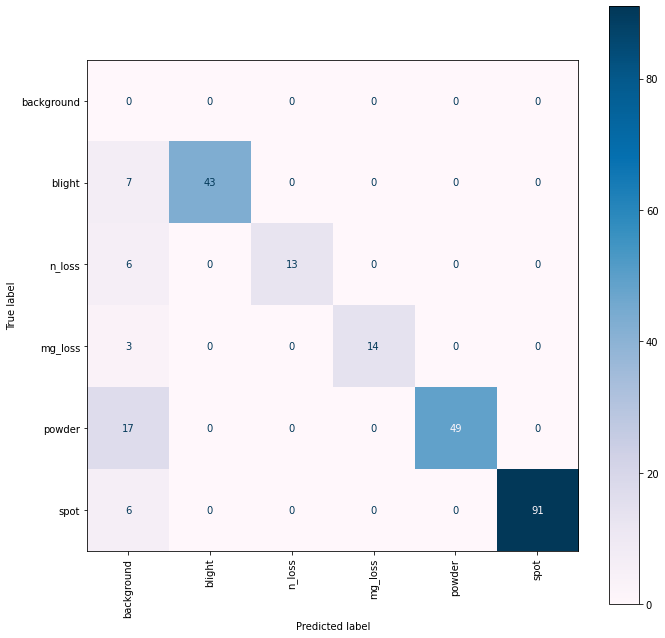

In [ ]:
learn.metrics[1].metric.plot()

# Save a Model

In [ ]:
!icevision --version

/bin/bash: icevision: command not found


In [ ]:
from icevision.models import *

In [ ]:
m = ClassMap(['blight', 'n_loss', 'mg_loss', 'powder', 'spot'])
m.get_classes()

['background', 'blight', 'n_loss', 'mg_loss', 'powder', 'spot']

In [ ]:
# เซฟโมเดลด้วยคำสั่ง `save_icevision_checkpoint`
checkpoint_path = "Leaf_disease(62per)_fastrcnn.pth"
save_icevision_checkpoint(
    model, 
    model_name='mmdet.faster_rcnn', 
    backbone_name='resnet101_fpn_2x',
    classes=m.get_classes(),
    img_size=512,
    filename=checkpoint_path,
    meta={"icevision_version": "0.12.0"}
)

In [ ]:
!cp /content/Leaf_disease_62per_fastrcnn.pth /content/drive/MyDrive

# Load Model


In [ ]:
! pip install torch==1.10.0+cu102 torchvision==0.11.1+cu102 -f https://download.pytorch.org/whl/torch_stable.html
! pip install mmcv-full==1.3.17 -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
! pip install mmdet==2.17.0
! pip install icevision[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from icevision.models import *

In [ ]:
# โหลดโมเดลที่เซฟมาเพื่อทำนายผลใน validation set
model_loaded = model_from_checkpoint("/content/drive/MyDrive/Leaf_disease_62per_fastrcnn.pth")

load checkpoint from local path: /content/drive/MyDrive/Leaf_disease_62per_fastrcnn.pth


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2022-07-15 11:58:03,290 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet101'}
2022-07-15 11:58:03,292 - mmcv - INFO - load model from: torchvision://resnet101
2022-07-15 11:58:03,296 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet101
2022-07-15 11:58:03,522 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-07-15 11:58:03,599 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-07-15 11:58:03,629 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-07-15 11:58:03,637

In [ ]:
model_type = model_loaded["model_type"]
backbone = model_loaded["backbone"]
class_map = model_loaded["class_map"]
img_size = model_loaded["img_size"]
model_type, backbone, class_map, img_size

(<module 'icevision.models.mmdet.models.faster_rcnn' from '/usr/local/lib/python3.7/dist-packages/icevision/models/mmdet/models/faster_rcnn/__init__.py'>,
 <ClassMap: {'background': 0, 'blight': 1, 'n_loss': 2, 'mg_loss': 3, 'powder': 4, 'spot': 5}>,
 512)

In [ ]:
valid = valid_ds

In [ ]:
valid[0]

BaseRecord

common: 
	- Filepath: /content/drive/MyDrive/Prototype_leaf(VOC)/images/102_spot_jpg.rf.e76922f06a3f61d801365fcb35701f1e.jpg
	- Img: 384x384x3 <np.ndarray> Image
	- Image size ImgSize(width=384, height=384)
	- Record ID: 102_spot_jpg.rf.e76922f06a3f61d801365fcb35701f1e
detection: 
	- BBoxes: [<BBox (xmin:221.25, ymin:139.5, xmax:326.25, ymax:226.5)>]
	- Class Map: <ClassMap: {'background': 0, 'blight': 1, 'n_loss': 2, 'mg_loss': 3, 'powder': 4, 'spot': 5}>
	- Labels: [5]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


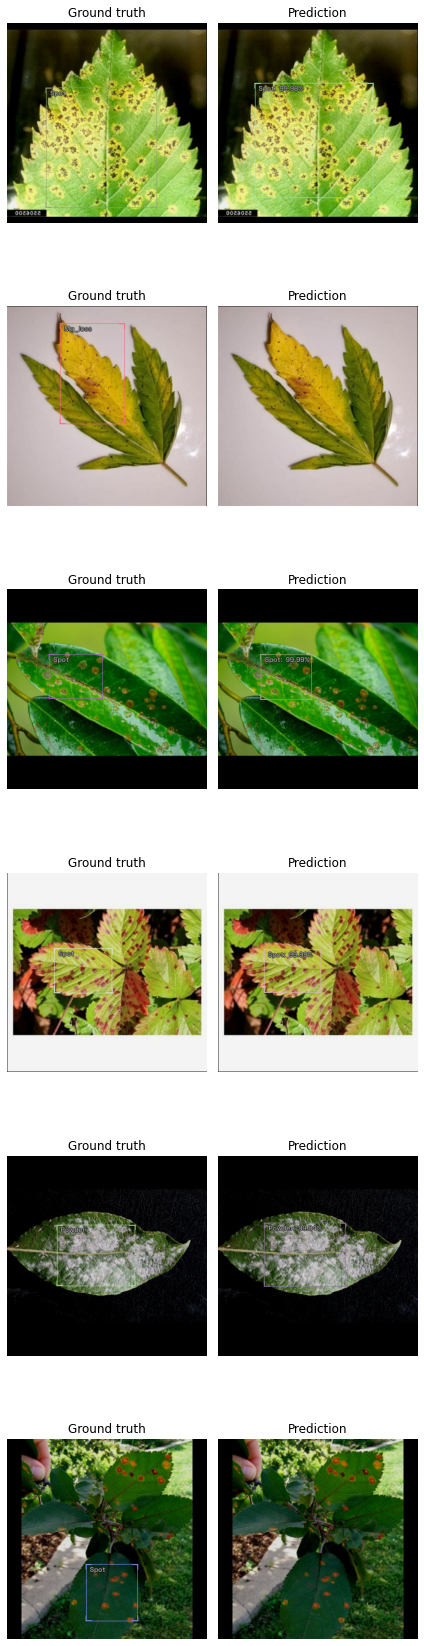

In [ ]:
model_type.show_results(model_loaded["model"], valid_ds, detection_threshold=0.6, )

In [ ]:
from PIL import Image, ImageOps

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


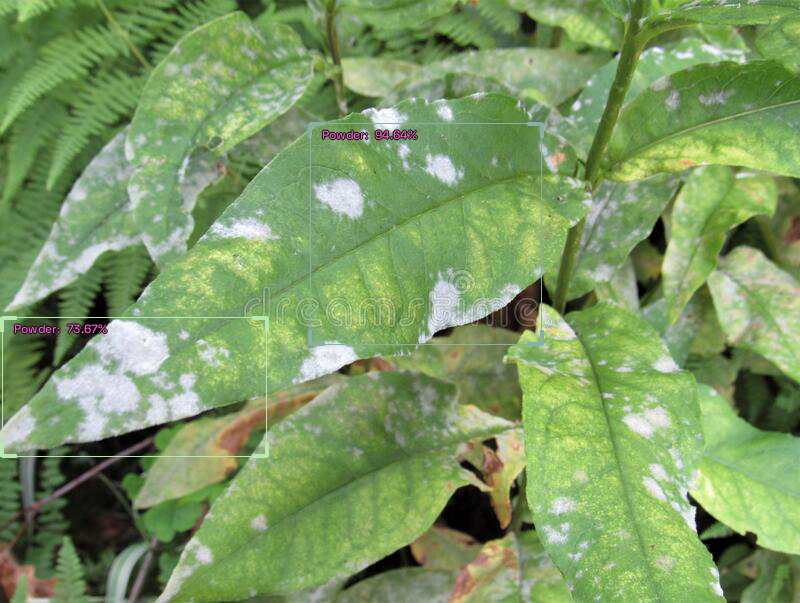

In [ ]:
img = Image.open("/content/drive/MyDrive/Leaf_dataset (raw)/powder_leaf (clean)/103_powder.jpg")
img = ImageOps.exif_transpose(img)
pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.1)
pred_dict['img']

In [ ]:
pred_dict['detection']['scores'][0], pred_dict['detection']['labels'][0]

(0.98769146, 'spot')